This Jupyter notebook implements a targeted submodelling approach for synthetic data generation using CTGAN. The analysis focuses specifically on the THEFT service code description partition of police incident data.

## Submodelling


In [17]:
import sys
import numpy.core.numeric as core_numeric
import types

# Create a dummy module named "numpy._core.numeric"
shim = types.ModuleType("numpy._core.numeric")
shim.__dict__.update(core_numeric.__dict__)
sys.modules["numpy._core.numeric"] = shim

import pickle
with open('processed_data_v1.pkl', 'rb') as f:
    df = pickle.load(f)

In [18]:
df.head()

incident_count date_created  hour_created max_final_priority  \
0               2   2023-08-11             7             PROMPT   
1               2   2023-02-16            20             PROMPT   
2               2   2024-09-05             0           STANDARD   
3               2   2024-09-02            14             PROMPT   
4               2   2022-04-12            19             PROMPT   

   inc_resourced  scrs_crime_inc   multi_member_ward  \
0          False           False          Dennistoun   
1           True           False              Lochee   
2          False            True          Leith Walk   
3           True           False              Almond   
4           True           False  Paisley North West   

                          datazone dzone_code     service_code_description  
0   Carntyne West and Haghill - 03  S01010244       ROAD TRAFFIC COLLISION  
1                  Charleston - 04  S01007848  ASSIST MEMBER OF THE PUBLIC  
2                 South Leith - 05  S01008796                        THEFT  
3  Ratho, Ingliston and Gogar - 01  S01008993      EXTERNAL AGENCY REQUEST  
4               Paisley North - 06  S01012158      EXTERNAL AGENCY REQUEST

### Preprocessing

In [19]:
# Removing unnecessary columns
df = df.drop(['incident_count','datazone', 'dzone_code'], axis=1)

In [20]:
df.head()

date_created  hour_created max_final_priority  inc_resourced  \
0   2023-08-11             7             PROMPT          False   
1   2023-02-16            20             PROMPT           True   
2   2024-09-05             0           STANDARD          False   
3   2024-09-02            14             PROMPT           True   
4   2022-04-12            19             PROMPT           True   

   scrs_crime_inc   multi_member_ward     service_code_description  
0           False          Dennistoun       ROAD TRAFFIC COLLISION  
1           False              Lochee  ASSIST MEMBER OF THE PUBLIC  
2            True          Leith Walk                        THEFT  
3           False              Almond      EXTERNAL AGENCY REQUEST  
4           False  Paisley North West      EXTERNAL AGENCY REQUEST

In [21]:
df.dtypes

date_created                datetime64[ns]
hour_created                         int32
max_final_priority                category
inc_resourced                         bool
scrs_crime_inc                        bool
multi_member_ward                 category
service_code_description          category
dtype: object

In [22]:
# covert bool vars to cat
bool_vars = ['scrs_crime_inc', 'inc_resourced']
df[bool_vars] = df[bool_vars].astype('category')

In [23]:
df.dtypes

date_created                datetime64[ns]
hour_created                         int32
max_final_priority                category
inc_resourced                     category
scrs_crime_inc                    category
multi_member_ward                 category
service_code_description          category
dtype: object

In [24]:
# converting date variable to a number in [startdate, enddate]
import pandas as pd

# make sure date_created is datetime
df['date_created'] = pd.to_datetime(df['date_created'])

# compute day offset from min date, then +1
min_date = df['date_created'].min()  # 2022-04-01 00:00:00
df['date_seq'] = (df['date_created'] - min_date).dt.days + 1

# compute min/max of each
min_date = df['date_created'].min()
max_date = df['date_created'].max()
min_seq  = df['date_seq'].min()
max_seq  = df['date_seq'].max()

# grab the corresponding dates from the mapped column
mapped_min_date = df.loc[df['date_seq'] == min_seq, 'date_created'].iloc[0]
mapped_max_date = df.loc[df['date_seq'] == max_seq, 'date_created'].iloc[0]

# sanity‐check
print(f"earliest actual date: {min_date}, mapped date at seq {min_seq}: {mapped_min_date}")
print(f" latest actual date: {max_date}, mapped date at seq {max_seq}: {mapped_max_date}")

earliest actual date: 2022-04-01 00:00:00, mapped date at seq 1: 2022-04-01 00:00:00
 latest actual date: 2025-03-31 00:00:00, mapped date at seq 1096: 2025-03-31 00:00:00


In [25]:
df = df.drop('date_created', axis=1)
df.head()

hour_created max_final_priority inc_resourced scrs_crime_inc  \
0             7             PROMPT         False          False   
1            20             PROMPT          True          False   
2             0           STANDARD         False           True   
3            14             PROMPT          True          False   
4            19             PROMPT          True          False   

    multi_member_ward     service_code_description  date_seq  
0          Dennistoun       ROAD TRAFFIC COLLISION       498  
1              Lochee  ASSIST MEMBER OF THE PUBLIC       322  
2          Leith Walk                        THEFT       889  
3              Almond      EXTERNAL AGENCY REQUEST       886  
4  Paisley North West      EXTERNAL AGENCY REQUEST        12

In [26]:
df.dtypes

hour_created                   int32
max_final_priority          category
inc_resourced               category
scrs_crime_inc              category
multi_member_ward           category
service_code_description    category
date_seq                       int64
dtype: object

### Training a CTGAN

In [27]:
# The aim is to filter data to get only incidents that are classified as THEFT
df_cleaned = df.copy()
dft = df_cleaned[df_cleaned['service_code_description'] == 'THEFT']

In [28]:
dft.head()

hour_created max_final_priority inc_resourced scrs_crime_inc  \
2               0           STANDARD         False           True   
6              15           STANDARD         False           True   
106            11           STANDARD         False           True   
107            12           STANDARD         False           True   
108            16           STANDARD          True           True   

            multi_member_ward service_code_description  date_seq  
2                  Leith Walk                    THEFT       889  
6    Craigentinny/Duddingston                    THEFT       419  
106           Torry/Ferryhill                    THEFT         3  
107           Torry/Ferryhill                    THEFT         5  
108           Torry/Ferryhill                    THEFT        16

In [39]:
pip install sdv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 32.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 29.9 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 737.4/737.4 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17/17 [sdv]32m16/17 [sdv]3]ho]]]
Note: you may need to restart the kernel to use updated packages.


In [69]:
from sdv.metadata import SingleTableMetadata

cat_cols  = ["max_final_priority", "service_code_description", 'scrs_crime_inc', 'inc_resourced', 'multi_member_ward']
dft[cat_cols] = dft[cat_cols].astype('object')

metadata = SingleTableMetadata()
metadata.detect_from_dataframe(dft)    # auto detecting the metadata information from the df

In [39]:
from sdv.metadata import Metadata

cat_cols  = ["max_final_priority", "service_code_description", 'scrs_crime_inc', 'inc_resourced', 'multi_member_ward']
dft[cat_cols] = dft[cat_cols].astype('object')

# 1. auto-detect metadata based in your data
metadata = Metadata.detect_from_dataframes({"incidents":dft})

# 2. carefully inspect and update your metadata
metadata.visualize()

metadata.validate()

# 3. when you're done, save it to a file for future use
metadata.save_to_json('my_final_metadata.json')

ValueError: A file named 'my_final_metadata.json' already exists in this folder. Please specify a different filename.

In [40]:
metadata

{
    "tables": {
        "incidents": {
            "columns": {
                "hour_created": {
                    "sdtype": "numerical"
                },
                "max_final_priority": {
                    "sdtype": "categorical"
                },
                "inc_resourced": {
                    "sdtype": "categorical"
                },
                "scrs_crime_inc": {
                    "sdtype": "categorical"
                },
                "multi_member_ward": {
                    "sdtype": "categorical"
                },
                "service_code_description": {
                    "sdtype": "categorical"
                },
                "date_seq": {
                    "sdtype": "numerical"
                }
            }
        }
    },
    "relationships": [],
    "METADATA_SPEC_VERSION": "V1"
}

In [41]:
from sdv.single_table import CTGANSynthesizer
ctgan = CTGANSynthesizer(
    metadata,
    epochs=300,
    batch_size=1024,
    pac=8,
    embedding_dim=128,
    generator_dim=(256, 256),
    discriminator_dim=(256, 256),
    generator_lr=2e-4,
    discriminator_lr=2e-4,
    cuda=True,
    verbose=True
)

/dcs/large/u2164966/MSc_Dissertation/myenv/lib64/python3.12/site-packages/sdv/single_table/base.py:128: UserWarning:

We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.



In [21]:
ctgan.fit(
    data=dft,
)

/dcs/large/u2164966/MSc_Dissertation/myenv/lib64/python3.12/site-packages/sdv/single_table/ctgan.py:252: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

Gen. (0.03) | Discrim. (-0.06): 100%|██████████| 300/300 [24:04<00:00,  4.81s/it] 


In [59]:
# Saving the model to a pickle file
ctgan.save(
    filepath='ctgan_theft.pkl'
)

In [29]:
from sdv.single_table import CTGANSynthesizer

# Loading the model from the pickle file
ctgan = CTGANSynthesizer.load(
    filepath='ctgan_theft.pkl'
)

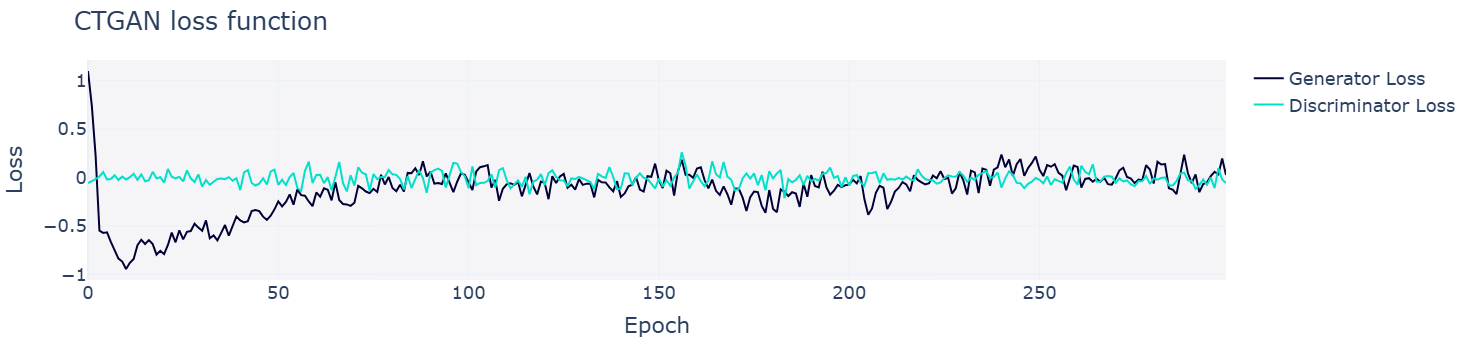

In [30]:
# Visualising the loss functions
fig = ctgan.get_loss_values_plot()
fig.show()

In [31]:
# Number of data points in real dataset
len(dft)

182229

In [32]:
# Generating synthetic data
synthetic_data = ctgan.sample(
    num_rows= 182229, # generating the same number of data points as the real dataset
    batch_size=1_000
)

Sampling rows: : 183000it [00:05, 33245.66it/s]                          


In [33]:
# Evaluating the synthetic data generated
pd.set_option('future.no_silent_downcasting', True)
from sdv.evaluation.single_table import run_diagnostic, evaluate_quality
from sdv.evaluation.single_table import get_column_plot

# 1. perform basic validity checks
diagnostic = run_diagnostic(dft, synthetic_data, metadata)

# # 2. measure the statistical similarity
# quality_report = evaluate_quality(dft, synthetic_data, metadata)

Generating report ...

(1/2) Evaluating Data Validity: |██████████| 7/7 [00:00<00:00, 63.52it/s]|
Data Validity Score: 100.0%

(2/2) Evaluating Data Structure: |██████████| 1/1 [00:00<00:00, 861.96it/s]|
Data Structure Score: 100.0%

Overall Score (Average): 100.0%



## Visual Investigation of synth and real Distributions

In [38]:
# Importing necessary libraries
import seaborn as sns
import matplotlib.pyplot as plt

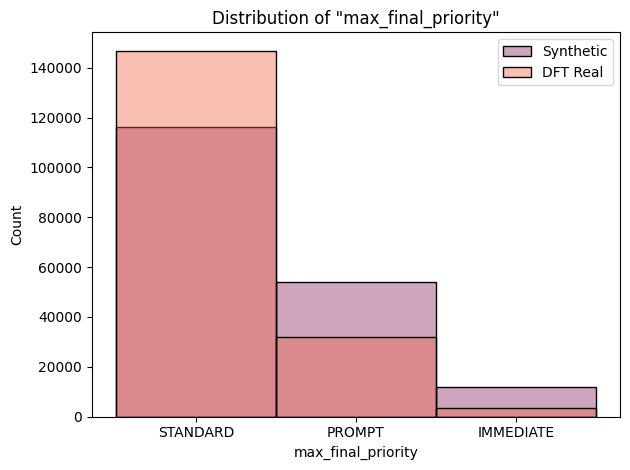

In [54]:
# Visualing the distribution of max_final_priority
pal = sns.color_palette("rocket", 2)

plt.figure()
sns.histplot(
    synthetic_data['max_final_priority'].dropna(),
    bins=30,
    kde=False,
    label='Synthetic',
    color=pal[0],
    alpha=0.4
)
sns.histplot(
    dft['max_final_priority'].dropna(),
    bins=30,
    kde=False,
    label='DFT Real',
    color=pal[1],
    alpha=0.4
)

plt.title('Distribution of "max_final_priority"')
plt.xlabel('max_final_priority')
plt.ylabel('Count')
plt.legend()
plt.tight_layout()
plt.show()

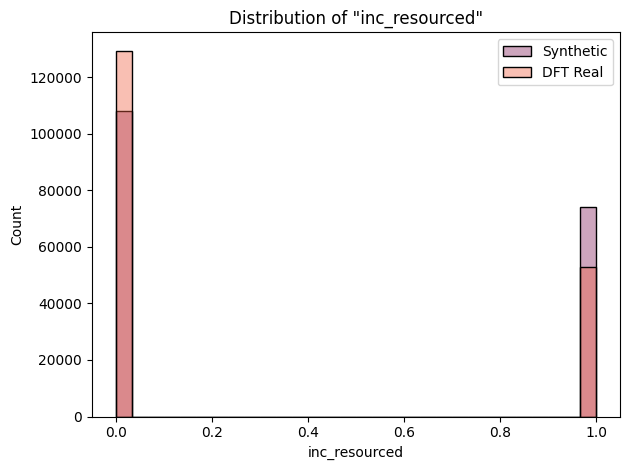

In [60]:
# Visualing the distribution of inc_resourced
pal = sns.color_palette("rocket", 2)

plt.figure()
sns.histplot(
    synthetic_data['inc_resourced'].dropna(),
    bins=30,
    kde=False,
    label='Synthetic',
    color=pal[0],
    alpha=0.4
)
sns.histplot(
    dft['inc_resourced'].dropna(),
    bins=30,
    kde=False,
    label='DFT Real',
    color=pal[1],
    alpha=0.4
)

plt.title('Distribution of "inc_resourced"')
plt.xlabel('inc_resourced')
plt.ylabel('Count')
plt.legend()
plt.tight_layout()
plt.show()

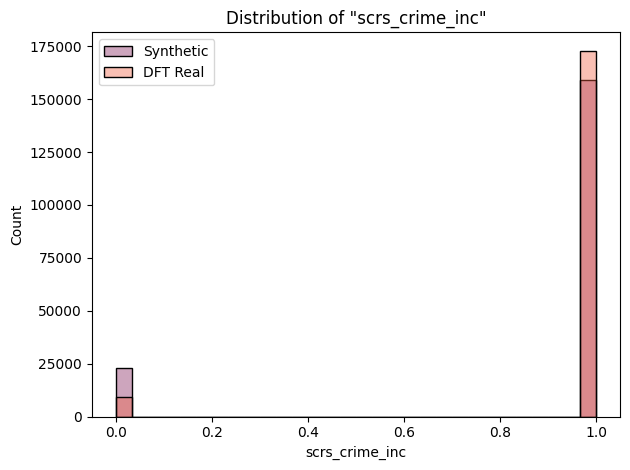

In [61]:
# Visualing the distribution of scrs_crime_inc
pal = sns.color_palette("rocket", 2)

plt.figure()
sns.histplot(
    synthetic_data['scrs_crime_inc'].dropna(),
    bins=30,
    kde=False,
    label='Synthetic',
    color=pal[0],
    alpha=0.4
)
sns.histplot(
    dft['scrs_crime_inc'].dropna(),
    bins=30,
    kde=False,
    label='DFT Real',
    color=pal[1],
    alpha=0.4
)

plt.title('Distribution of "scrs_crime_inc"')
plt.xlabel('scrs_crime_inc')
plt.ylabel('Count')
plt.legend()
plt.tight_layout()
plt.show()

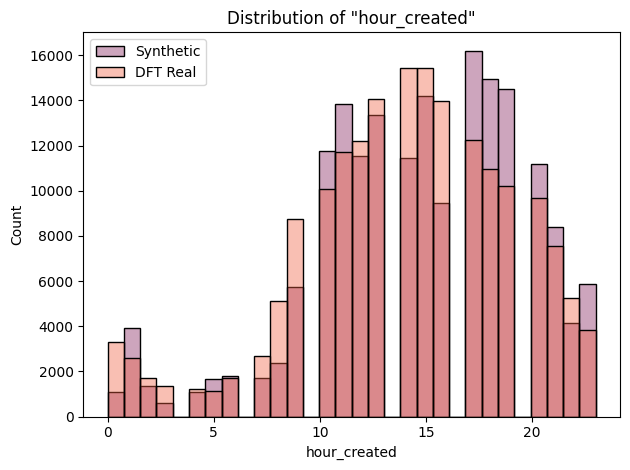

In [63]:
# Visualing the distribution of hour_created
pal = sns.color_palette("rocket", 2)

plt.figure()
sns.histplot(
    synthetic_data['hour_created'].dropna(),
    bins=30,
    kde=False,
    label='Synthetic',
    color=pal[0],
    alpha=0.4
)
sns.histplot(
    dft['hour_created'].dropna(),
    bins=30,
    kde=False,
    label='DFT Real',
    color=pal[1],
    alpha=0.4
)

plt.title('Distribution of "hour_created"')
plt.xlabel('hour_created')
plt.ylabel('Count')
plt.legend()
plt.tight_layout()
plt.show()

In [67]:
import numpy as np
# Difference between the date_seq columns of real and synthetic data
# 2) Extract unique sorted numpy arrays
real_vals  = np.sort(dft['date_seq'].unique())
synth_vals = np.sort(synthetic_data['date_seq'].unique())

# 3) Compute differences between the two sets
missing_in_synth = np.setdiff1d(real_vals, synth_vals)
missing_in_real  = np.setdiff1d(synth_vals, real_vals)

In [68]:
print("Dates in REAL but missing in SYNTHETIC:", missing_in_synth)
print("Dates in SYNTHETIC but missing in REAL: ", missing_in_real)


Dates in REAL but missing in SYNTHETIC: []
Dates in SYNTHETIC but missing in REAL:  []


In [72]:
print(f"Max value of date: {dft['date_seq'].max()}")
print(f"Min value of date: {dft['date_seq'].min()}")

Max value of date: 1096
Min value of date: 1


In [91]:
pip install --no-user statsmodels

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 43.3 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [statsmodels] [statsmodels]
Note: you may need to restart the kernel to use updated packages.


## Multi_member_ward lookup

In [7]:
pip install --no-user openpyxl --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [openpyxl]1/2 [openpyxl]
Note: you may need to restart the kernel to use updated packages.


In [18]:
pip install --no-user geopandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.7/27.7 MB 45.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 37.6 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 32.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [geopandas]/4 [geopandas]
Note: you may need to restart the kernel to use updated packages.


In [10]:
import pandas as pd

mmw_lookup = pd.read_excel('mmw2007_dz2011_lookup.xlsx', index_col=None)

In [11]:
mmw_lookup.head()

dz       dzname    MMWCODE    MMW_DEFAULT
0  S01006506  Culter - 01  S13002484  Lower Deeside
1  S01006507  Culter - 02  S13002484  Lower Deeside
2  S01006508  Culter - 03  S13002484  Lower Deeside
3  S01006509  Culter - 04  S13002484  Lower Deeside
4  S01006510  Culter - 05  S13002484  Lower Deeside

In [13]:
synthetic_data.head()

hour_created max_final_priority inc_resourced scrs_crime_inc  \
0            14           STANDARD         False           True   
1            21           STANDARD         False           True   
2            15             PROMPT          True           True   
3            11           STANDARD          True           True   
4            12           STANDARD         False           True   

              multi_member_ward service_code_description  date_seq  
0                      Highland                    THEFT       961  
1  Rutherglen Central and North                    THEFT      1041  
2                Inverness West                    THEFT       441  
3      Girvan and South Carrick                    THEFT       317  
4                 Kinross-shire                    THEFT       508

⚠️  Unmatched ward names:
   Real only : ['Airyhall/Broomhill/Garthdee', 'Anderston/City/Yorkhill', 'Arbroath East & Lunan', 'Arbroath West, Letham And Friockheim', 'Barraigh Bhatarsaigh Eirisgeigh Uibhist Deas', 'Barrhead, Liboside And Uplawmoor', 'Bishopbriggs North And Campsie', 'Bishopton, Bridge Of Weir & Langbank', 'Brechin & Edzell', 'Cardonald', 'Carnoustie & District', 'Castle Douglas And Crocketford', 'Clarkston, Netherlee And Williamwood', 'Coatbridge North', 'Colinton/Fairmilehead', 'Corstorphine/Murrayfield', 'Craigentinny/Duddingston', 'Cumbernauld East', 'Dee And Glenkens', 'Dennistoun', 'Drum Brae/Gyle', 'Drumchapel/Anniesland', 'Dyce/Bucksburn/Danestone', 'Eilean A Cheo', 'Erskine & Inchinnan', 'Forfar & District', 'Fountainbridge/Craiglockhart', 'Ft William And Ardnamurchan', 'Garscadden/Scotstounhill', 'George St/Harbour', 'Glenboig And Moodiesburn', 'Hazlehead/Queens Cross/Countesswells', 'Hilton/Woodside/Stockethill', 'Houston, Crosslee & Linwood', 'Inverclyde Cent

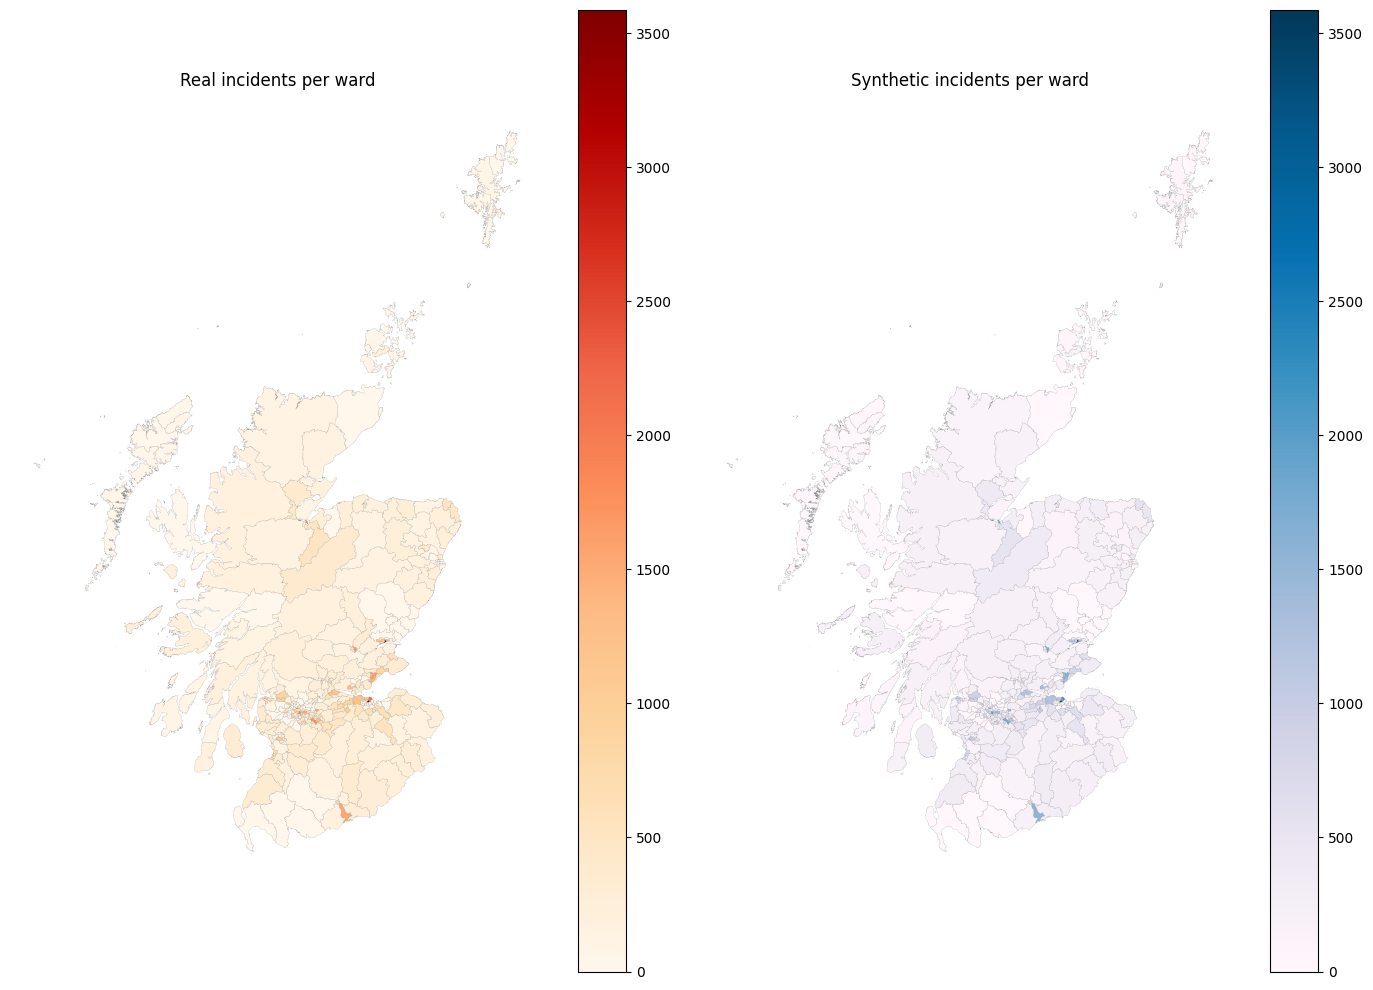

In [29]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
plt.rcParams.update({"figure.facecolor": "white"})

# --- 1. Read shapes -------------------------------------------------
ward_zip = "4th_Review_2007_2017_All_Scotland_wards"
wards_gdf = gpd.read_file(ward_zip, layer="All_Scotland_wards_4th")

def norm_name(s):
    return s.strip().title().replace("’", "'")

wards_gdf["ward_name"] = wards_gdf["Name"].apply(norm_name)

# --- 2. Normalise ward names in both tables -------------------------
for d in (df, synthetic_data):
    d["ward_name"] = d["multi_member_ward"].apply(norm_name)

# --- 3. Counts per ward --------------------------------------------
real_by_ward = (
    df.groupby("ward_name", as_index=False)
      .size()
      .rename(columns={"size": "real_cnt"})
)

syn_by_ward = (
    synthetic_data.groupby("ward_name", as_index=False)
                  .size()
                  .rename(columns={"size": "syn_cnt"})
)

# --- 4. Join to geometry -------------------------------------------
wards = (
    wards_gdf
        .merge(real_by_ward, on="ward_name", how="left")
        .merge(syn_by_ward,  on="ward_name", how="left")
        .fillna({"real_cnt": 0, "syn_cnt": 0})
)

# Warn about any bad matches
bad_real = set(real_by_ward["ward_name"]) - set(wards["ward_name"])
bad_syn  = set(syn_by_ward["ward_name"])  - set(wards["ward_name"])
if bad_real or bad_syn:
    print("⚠️  Unmatched ward names:")
    if bad_real:
        print("   Real only :", sorted(bad_real))
    if bad_syn:
        print("   Synthetic:", sorted(bad_syn))
    print()

# --- 5. Plot --------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(14, 10), sharex=True, sharey=True)
vmax = wards[["real_cnt", "syn_cnt"]].to_numpy().max()

wards.plot(column="real_cnt", cmap="OrRd", linewidth=0.1, edgecolor="grey",
           ax=axes[0], legend=True, vmin=0, vmax=vmax)
axes[0].set_title("Real incidents per ward")
axes[0].axis("off")

wards.plot(column="syn_cnt", cmap="PuBu", linewidth=0.1, edgecolor="grey",
           ax=axes[1], legend=True, vmin=0, vmax=vmax)
axes[1].set_title("Synthetic incidents per ward")
axes[1].axis("off")

plt.tight_layout()
plt.show()

In [34]:
Synthetic = ['Airyhall/Broomhill/Garthdee', 'Anderston/City/Yorkhill', 'Arbroath East & Lunan', 'Arbroath West, Letham And Friockheim', 'Barraigh Bhatarsaigh Eirisgeigh Uibhist Deas', 'Barrhead, Liboside And Uplawmoor', 'Bishopbriggs North And Campsie', 'Bishopton, Bridge Of Weir & Langbank', 'Brechin & Edzell', 'Cardonald', 'Carnoustie & District', 'Castle Douglas And Crocketford', 'Clarkston, Netherlee And Williamwood', 'Coatbridge North', 'Colinton/Fairmilehead', 'Corstorphine/Murrayfield', 'Craigentinny/Duddingston', 'Cumbernauld East', 'Dee And Glenkens', 'Dennistoun', 'Drum Brae/Gyle', 'Drumchapel/Anniesland', 'Dyce/Bucksburn/Danestone', 'Eilean A Cheo', 'Erskine & Inchinnan', 'Forfar & District', 'Fountainbridge/Craiglockhart', 'Ft William And Ardnamurchan', 'Garscadden/Scotstounhill', 'George St/Harbour', 'Glenboig And Moodiesburn', 'Hazlehead/Queens Cross/Countesswells', 'Hilton/Woodside/Stockethill', 'Houston, Crosslee & Linwood', 'Inverclyde Central', 'Inverness Millburn', 'Irvine South', 'Johnstone North, Kilbarchan, Howwood And Lochwinnoch', 'Johnstone South And Elderslie', 'Kincorth/Nigg/Cove', 'Kingswells/Sheddocksley/Summerhill', 'Kirkintilloch East And North And Twechar', 'Kirriemuir & Dean', 'Lenzie & Kirkintilloch South', 'Liberton/Gilmerton', 'Lochgelly, Cardenden And Benarty', 'Maryhill', 'Mid Galloway And Wigtown West', 'Midstocket/Rosemount', 'Monifieth & Sidlaw', 'Montrose & District', 'Morningside', 'Musselburgh', 'Nairn And Cawdor', 'Newlands/Auldburn', 'Newton Mearns North And Neilston', 'Newton Mearns South And Eaglesham', 'North East - Glasgow', 'North East - Tayside', 'North Isles - Orkney', 'North Isles - Shetland', 'Northfield/Mastrick North', 'Paisley East And Central', 'Paisley North East And Ralston', 'Paisley South East', 'Partick East/Kelvindale', 'Portobello/Craigmillar', 'Preston/Seton/Gosford', 'Renfrew North And Braehead', 'Renfrew South & Gallowhill', 'Saltcoats', "Sgir' Uige Agus Ceann A Tuath Nan Loch", 'Sighthill/Gorgie', 'Southside/Newington', 'Springburn/Robroyston', 'Steornabhagh A Deas', 'Steornabhagh A Tuath', 'Stepps, Chryston And Muirhead', 'Stevenston', 'Stirling North', 'Stranraer And The Rhins', 'Thurso And Northwest Caithness', 'Tillydrone/Seaton/Old Aberdeen', 'Torry/Ferryhill', 'Tranent, Wallyford And Macmerry', 'Victoria Park', 'Wick And East Caithness']
len(Synthetic)


87

## Hellingers distance

In [94]:
def hellinger_distance(p, q, bins=20):
    """
    Compute Hellinger distance between two 1-D distributions.

    Parameters
    ----------
    p, q : 1-D arrays or pd.Series
        Samples from the real and synthetic data.
    bins : int or array-like
        If int, uses equal-width bins (good default for continuous vars).
        If you pass an explicit bin-edge array, the same edges are reused
        for both p and q.

    Returns
    -------
    float in [0, 1]
        0   → identical distributions  
        1   → maximally different
    """
    # Choose common bin edges
    if np.isscalar(bins):
        edges = np.histogram_bin_edges(np.concatenate((p, q)), bins=bins)
    else:
        edges = bins

    # Normalised histograms ⇒ empirical PMFs
    p_hist, _ = np.histogram(p, bins=edges, density=True)
    q_hist, _ = np.histogram(q, bins=edges, density=True)

    # Replace nans that can appear if column is constant
    p_hist = np.nan_to_num(p_hist)
    q_hist = np.nan_to_num(q_hist)

    return np.sqrt(0.5 * np.sum((np.sqrt(p_hist) - np.sqrt(q_hist))**2))

In [95]:
def hellinger_categorical(p, q):
    # aligned on the union of category labels
    all_cats = sorted(set(p).union(q))
    p_probs = np.array(p.value_counts(normalize=True).reindex(all_cats, fill_value=0))
    q_probs = np.array(q.value_counts(normalize=True).reindex(all_cats, fill_value=0))
    return np.sqrt(0.5 * np.sum((np.sqrt(p_probs) - np.sqrt(q_probs))**2))


In [96]:
distances = {}

for col in dft.columns:
    real_col = dft[col].dropna()
    synth_col = synthetic_data[col].dropna()

    if pd.api.types.is_numeric_dtype(real_col):
        d = hellinger_distance(real_col, synth_col, bins=20)
    else:
        d = hellinger_categorical(real_col, synth_col)

    distances[col] = d

hellinger_series = pd.Series(distances).sort_values()

In [97]:
hellinger_series # this data has only one service_code_description so the 0 value is expected

service_code_description    0.000000
date_seq                    0.011197
hour_created                0.084957
inc_resourced               0.087004
scrs_crime_inc              0.096612
multi_member_ward           0.117210
max_final_priority          0.141530
dtype: float64

## tSNE visualisation to check for mode collapse

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Combine data and create labels
X_combined = np.vstack([dft, synthetic_data])
labels = np.array(['Real'] * len(dft) + ['Synthetic'] * len(synthetic_data))

# Optional: Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_combined)

# Apply t-SNE
tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=30)
X_embedded = tsne.fit_transform(X_scaled)

# Plot
plt.figure(figsize=(8, 6))
for label in np.unique(labels):
    idx = labels == label
    plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1], label=label, alpha=0.6)
plt.legend()
plt.title('t-SNE Visualization of Real vs. Synthetic Data')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()


NameError: name 'dft' is not defined

## TSTR

In [23]:
pip install --no-user dython

Note: you may need to restart the kernel to use updated packages.


In [33]:
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error
from sklearn.preprocessing import LabelEncoder

def calculate_utility_score(real_df, synth_df, target_col, task='classification', test_size=0.3):
    """
    Measures the utility of synthetic data by comparing the performance of a model
    trained on it (TSTR) against a model trained on real data (RTR).

    Args:
        real_df (pd.DataFrame): The real dataset.
        synth_df (pd.DataFrame): The synthetic dataset.
        target_col (str): The name of the target column for the ML task.
        task (str): The type of machine learning task, either 'classification' or 'regression'.
        test_size (float): The proportion of the real dataset to reserve for testing.

    Returns:
        dict: A dictionary containing the performance of the model trained on real data (RTR),
              the model trained on synthetic data (TSTR), and the final utility score.
    """
    # 1. Prepare dataframes
    X_real = real_df.drop(columns=[target_col])
    y_real = real_df[target_col]
    X_synth = synth_df.drop(columns=[target_col])
    y_synth = synth_df[target_col]
    
    # 2. Preprocessing: Convert object columns to 'category' for LightGBM
    real_obj_cols = X_real.select_dtypes(include='object').columns
    synth_obj_cols = X_synth.select_dtypes(include='object').columns
    all_obj_cols = real_obj_cols.union(synth_obj_cols)

    # Convert these columns to 'category' in both DataFrames
    for col in all_obj_cols:
        if col in X_real.columns:
            X_real[col] = X_real[col].astype('category')
        if col in X_synth.columns:
            X_synth[col] = X_synth[col].astype('category')

    # Encode target column if it's categorical
    if y_real.dtype == 'object':
        le = LabelEncoder()
        y_real = le.fit_transform(y_real)
        y_synth = le.transform(y_synth) # Use the same encoder

    # 3. Split the real data to create a holdout test set
    X_real_train, X_real_test, y_real_train, y_real_test = train_test_split(
        X_real, y_real, test_size=test_size, random_state=42, stratify=(y_real if task=='classification' else None)
    )

    # 4. Define the model based on the task
    if task == 'classification':
        model = lgb.LGBMClassifier(random_state=42)
        metric = f1_score
        metric_params = {'average': 'weighted'}
    else: # regression
        model = lgb.LGBMRegressor(random_state=42)
        metric = mean_squared_error
        metric_params = {'squared': False} # for RMSE

    # --- Benchmark: Train on Real, Test on Real (RTR) ---
    model.fit(X_real_train, y_real_train)
    y_pred_rtr = model.predict(X_real_test)
    rtr_score = metric(y_real_test, y_pred_rtr, **metric_params)

    # --- Utility Test: Train on Synthetic, Test on Real (TSTR) ---
    model.fit(X_synth, y_synth)
    y_pred_tstr = model.predict(X_real_test)
    tstr_score = metric(y_real_test, y_pred_tstr, **metric_params)

    # 5. Calculate final utility score
    if task == 'classification': # Higher is better
        utility_score = tstr_score / rtr_score if rtr_score > 0 else 0
    else: # Lower is better (RMSE)
        utility_score = rtr_score / tstr_score if tstr_score > 0 else 0

    return {
        'rtr_score': rtr_score,
        'tstr_score': tstr_score,
        'utility_score': utility_score
    }

In [34]:
dft['multi_member_ward'].value_counts() # Sgire an Rubha has only one data point in real dataset

multi_member_ward
Anderston/City/Yorkhill                      8787
City Centre                                  8351
George St/Harbour                            2472
Leith Walk                                   2231
Maryfield                                    2180
                                             ... 
An Taobh Siar agus Nis                          6
Beinn na Foghla agus Uibhist a Tuath            6
East Mainland, South Ronaldsay and Burray       5
Shetland South                                  5
Sgire an Rubha                                  1
Name: count, Length: 354, dtype: int64

In [35]:
dft = dft[dft['multi_member_ward'] != 'Sgire an Rubha']

In [36]:
result = calculate_utility_score(dft, synthetic_data, target_col='multi_member_ward', task='classification')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003512 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 289
[LightGBM] [Info] Number of data points in the train set: 127559, number of used features: 5
[LightGBM] [Info] Start training from score -7.767350
[LightGBM] [Info] Start training from score -7.536827
[LightGBM] [Info] Start training from score -7.522228
[LightGBM] [Info] Start training from score -5.021743
[LightGBM] [Info] Start training from score -6.473131
[LightGBM] [Info] Start training from score -7.121605
[LightGBM] [Info] Start training from score -6.045907
[LightGBM] [Info] Start training from score -4.924381
[LightGBM] [Info] Start training from score -7.824509
[LightGBM] [Info] Start training from score -10.370040
[LightGBM] [Info] Start training from score -3.031964
[LightGBM] [Info] Start training from score -6.541399

In [37]:
print(result)

{'rtr_score': 0.004783708679328092, 'tstr_score': 0.003836893548154737, 'utility_score': 0.8020750855367007}


## Propensity score (LightGBM)

In [17]:
# Creating copies of dfs
dft_copy = dft.copy()
synthetic_data_copy = synthetic_data.copy()

dft_copy["is_real"]          = 1        # positive class
synthetic_data_copy["is_real"] = 0        # negative class

full = pd.concat([dft_copy, synthetic_data_copy], ignore_index=True)

In [19]:
full.dtypes

hour_created                 int32
max_final_priority          object
inc_resourced               object
scrs_crime_inc              object
multi_member_ward           object
service_code_description    object
date_seq                     int64
is_real                      int64
dtype: object

In [20]:
pip install --no-user lightgbm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 35.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [21]:
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split

# Assuming 'full' is your combined DataFrame from the prompt

# Define features (X) and target (y)
X = full.drop('is_real', axis=1)
y = full['is_real']

# Convert object columns to the 'category' dtype for LightGBM
for col in X.select_dtypes(include='object').columns:
    X[col] = X[col].astype('category')

# Split data for training and testing the classifier
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Initialize and train the LightGBM classifier
lgbm = lgb.LGBMClassifier(objective='binary', random_state=42)
lgbm.fit(X_train, y_train)

# Get propensity scores for the entire dataset
# The [:, 1] selects the probability of the positive class (is_real=1)
full['p_score'] = lgbm.predict_proba(X)[:, 1]

# Display the scores for real vs. synthetic data
print(full.groupby('is_real')['p_score'].describe())

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 127560, number of negative: 127560
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004625 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 613
[LightGBM] [Info] Number of data points in the train set: 255120, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
            count      mean       std       min       25%       50%       75%  \
is_real                                                                         
0        182229.0  0.414759  0.183827  0.018197  0.274096  0.409378  0.552578   
1        182229.0  0.5

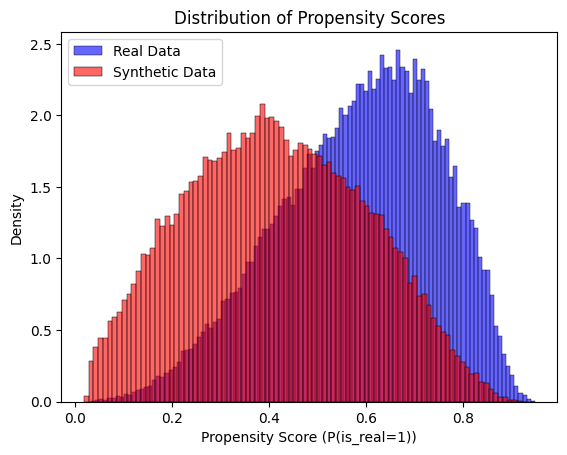

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

# Separate the scores for real and synthetic data
real_scores = full[full['is_real'] == 1]['p_score']
synthetic_scores = full[full['is_real'] == 0]['p_score']

# Plot the distributions
sns.histplot(real_scores, color="blue", label='Real Data', stat='density', alpha=0.6)
sns.histplot(synthetic_scores, color="red", label='Synthetic Data', stat='density', alpha=0.6)

plt.legend()
plt.title('Distribution of Propensity Scores')
plt.xlabel('Propensity Score (P(is_real=1))')
plt.show()